# Construct Your Own CKCNN

In this notebook, we illustrate the construction of a simple CKCNN, proposed in our work [CKConv: Continuous Kernel Convolution for Sequential Data](https://arxiv.org/abs/2102.02611). The code provided here is a simplified version of the main code. For baseline comparisons please refer to the main code.

In particular, we will:
* Use the `ckconv` library to create a simple CKCNN.

**Note:** If you are interested in understanding the inner working of a `CKConv` layer, please refer to the notebook `demo/construct_your_own_ckconv_layer.ipynb`.

Let's go! First, we import some packages:

In [1]:
# Append .. to path
import os,sys
ckconv_source =  os.path.join(os.getcwd(), '..')
if ckconv_source not in sys.path:
    sys.path.append(ckconv_source)
    
import numpy as np
import torch
from torch.nn.utils import weight_norm

import ckconv

from matplotlib import pyplot as plt

#### CKConv

Fist we recall how to construct a continuous kernel convolutional layer. A CKConv has the following init signature:

```
ckconv.CKConv(
    in_channels: int,           # Input channels of the layer
    out_channels: int,          # Output channels of the layer
    hidden_channels: int,       # Hidden units of the MLP parameterizing the conv. kernel. (KernelNet)
    activation_function: str,   # Activation function used in the MLP parameterizing the conv. kernel. (KernelNet)
    norm_type: str,             # Normalization type used in the MLP parameterizing the conv. kernel. (KernelNet) 
                                  -- Will be used in non-Sine KernelNets only --.
    dim_linear: int,            # Dimensionality of the expected input 1D, 2D, etc. (TODO) -- only works with 1 now --.
    bias: bool,                 # Use bias 
    omega_0: float,             # The omega_0 parameter of the MLP parameterizing the conv. kernel. (KernelNet) 
                                  -- Will be used only in Sine KernelNets only --.
    weight_dropout: float,      # Weight_dropout rate (Dropout vaues in the sampled convolutional kernel).
)
```

In [2]:
# Example:
in_channels = 10
out_channels = 10
hidden_channels = 32
activation_function = 'Sine'
norm_type = ''
dim_linear = 1
bias = True
omega_0 = 30.5
weight_dropout = 0.0

ckconv_example = ckconv.CKConv(in_channels,
                              out_channels,
                              hidden_channels,
                              activation_function,
                              norm_type,
                              dim_linear,
                              bias,
                              omega_0,
                              weight_dropout,
                              )

#### CKBlock

Now, we construct a `CKBlock` that follows the structure shown in the following image (Based on the residual blocks of the [TCN](https://arxiv.org/abs/1803.01271)):

<img src="../net_structure.png" width=480 />

The `CKBlock` has the following init signature:

```
Init signature:
ckconv.CKBlock(
    in_channels: int,                     # Input channels of the block
    out_channels: int,                    # Output (and hidden) channels of the block
    kernelnet_hidden_channels: int,       # Hidden units of the MLP parameterizing the conv. kernel. (KernelNet)
    kernelnet_activation_function: str,   # Activation function used in the MLP parameterizing the conv. kernel. (KernelNet)
    kernelnet_norm_type: str,             # Normalization type used in the MLP parameterizing the conv. kernel. (KernelNet) 
                                            -- Will be used in non-Sine KernelNets only --.
    dim_linear: int,                      # Dimensionality of the expected input 1D, 2D, etc. (TODO) -- only works with 1 now --.
    bias: bool,                           # Use bias 
    omega_0: bool,                        # The omega_0 parameter of the MLP parameterizing the conv. kernel. (KernelNet) 
                                            -- Will be used only in Sine KernelNets only --.
    dropout: float,                       # Layerwise Dropout rate
    weight_dropout: float,                # Weight_dropout rate (Dropout vaues in the sampled convolutional kernels).
)
```

In [3]:
# Example:
in_channels = 10
out_channels = 10
kernelnet_hidden_channels = 32
kernelnet_activation_function = 'Sine'
kernelnet_norm_type = ''
dim_linear = 1
bias = True
omega_0 = 30.5
dropout = 0.1
weight_dropout = 0.0

ckconv_example = ckconv.CKBlock(in_channels,
                                out_channels,
                                kernelnet_hidden_channels,
                                kernelnet_activation_function,
                                kernelnet_norm_type,
                                dim_linear,
                                bias,
                                omega_0,
                                dropout,
                                weight_dropout,
                               )

### CKCNN

In order to construct a `CKCNN`, we will first construct a `CKCNN_backbone`, which implements a neural network composed of `num_blocks` `CKBlocks`. 
Next, we add a `Linear` layer, which is applied to the hidden representation at the last spatial position of the last hidden representation. 

##### CKCNN_backbone

In [4]:
class CKCNN_backbone(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_blocks: int,
        kernelnet_hidden_channels: int,
        kernelnet_activation_function: str,
        kernelnet_norm_type: str,
        dim_linear: int,
        bias: bool,
        omega_0: bool,
        dropout: float,
        weight_dropout: float,
    ):
        super().__init__()
        
        # Add num_blocks CKBlocks to a sequential called self.backbone
        blocks = []
        for i in range(num_blocks):
            block_in_channels = in_channels if i == 0 else hidden_channels
            blocks.append(
                ckconv.nn.CKBlock(
                    block_in_channels,
                    hidden_channels,
                    kernelnet_hidden_channels,
                    kernelnet_activation_function,
                    kernelnet_norm_type,
                    dim_linear,
                    bias,
                    omega_0,
                    dropout,
                    weight_dropout,
                )
            )
        self.backbone = torch.nn.Sequential(*blocks)

    def forward(self, x):
        return self.backbone(x)

#### CKCNN

In [5]:
class CKCNN(CKCNN_backbone):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_blocks: int,
        kernelnet_hidden_channels: int,
        kernelnet_activation_function: str,
        kernelnet_norm_type: str,
        dim_linear: int,
        bias: bool,
        omega_0: bool,
        dropout: float,
        weight_dropout: float,
    ):
        super().__init__(
            in_channels,
            hidden_channels,
            num_blocks,
            kernelnet_hidden_channels,
            kernelnet_activation_function,
            kernelnet_norm_type,
            dim_linear,
            bias,
            omega_0,
            dropout,
            weight_dropout,
        )

        self.finallyr = torch.nn.Linear(
            in_features=hidden_channels, out_features=out_channels
        )
        # Initialize finallyr
        self.finallyr.weight.data.normal_(
            mean=0.0,
            std=0.01,
        )
        self.finallyr.bias.data.fill_(value=0.0)

    def forward(self, x):
        out = self.backbone(x)
        out = self.finallyr(out[:, :, -1])
        return out

In [6]:
# Construct network:
in_channels = 3
out_channels = 10
hidden_channels = 20
num_blocks = 2
kernelnet_hidden_channels = 32
kernelnet_activation_function = 'Sine'
kernelnet_norm_type = ''
dim_linear = 1
bias = True
omega_0 = 30.5
dropout = 0.1
weight_dropout = 0.0

network = CKCNN(in_channels,
                out_channels,
                hidden_channels,
                num_blocks,
                kernelnet_hidden_channels,
                kernelnet_activation_function,
                kernelnet_norm_type,
                dim_linear,
                bias,
                omega_0,
                dropout,
                weight_dropout,
               )
network.to('cuda')

CKCNN(
  (backbone): Sequential(
    (0): CKBlock(
      (cconv1): CKConv(
        (Kernel): KernelNet(
          (kernel_net): Sequential(
            (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
            (1): Expression()
            (2): Identity()
            (3): Expression()
            (4): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
            (5): Expression()
            (6): Identity()
            (7): Expression()
            (8): Conv1d(32, 60, kernel_size=(1,), stride=(1,))
            (9): Identity()
          )
        )
      )
      (cconv2): CKConv(
        (Kernel): KernelNet(
          (kernel_net): Sequential(
            (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
            (1): Expression()
            (2): Identity()
            (3): Expression()
            (4): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
            (5): Expression()
            (6): Identity()
            (7): Expression()
            (8): Conv1d(32, 400, kernel_size=(1,

Voila! We have constructed a CKCNN. We let now an in_signal go through the network:

In [7]:
# 
batch_size = 10
in_channels = 3
signal_length = 1000
in_signal = torch.rand([batch_size, in_channels, signal_length])

out = network(in_signal.to('cuda'))
out.shape

torch.Size([10, 10])

Now we look at some of the kernels at initialization of the network:

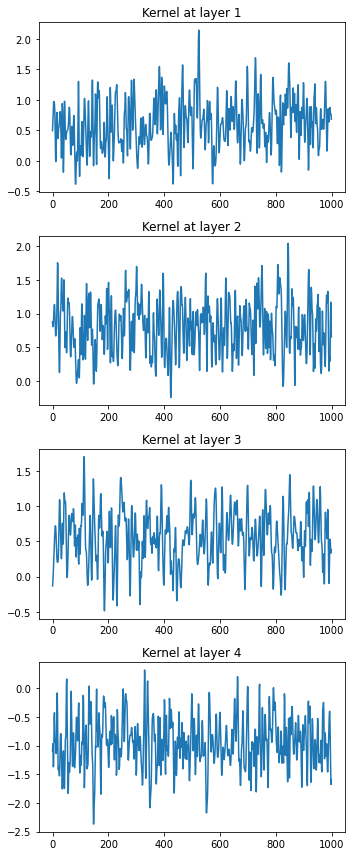

In [8]:
figsize = (5, 12)

fig, axs = plt.subplots(nrows=4, ncols=1,figsize=figsize)

counter = 0
for m in network.modules():
    if isinstance(m, ckconv.CKConv):
        
        axs[counter].set_title('Kernel at layer {}'.format(counter + 1))
        axs[counter].plot(m.conv_kernel.view(-1, signal_length)[0].detach().cpu().numpy())
        counter = counter + 1
        
plt.tight_layout()
plt.show()

Interestingly, we see that our filters are already quite expressive at initialization. 

Now we look at the number of parameters and the dimension of the filters of the network:

In [9]:
# ------------------------------
# Parameter counter
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# -----------------------------

print('Convolutional Kernel Sizes:')
for m in network.modules():
    if isinstance(m, ckconv.CKConv):
        print(m.conv_kernel.shape)
    elif isinstance(m, torch.nn.Linear):
        print(m.weight.shape)
         
print('Number of parameters: {}'.format(num_params(network)))

Convolutional Kernel Sizes:
torch.Size([20, 3, 1000])
torch.Size([20, 20, 1000])
torch.Size([20, 20, 1000])
torch.Size([20, 20, 1000])
torch.Size([10, 20])
Number of parameters: 48106


Note that a conventional CNN with filters of this dimensionality would have a total of **20 * 3 * 1000 + 3 * 20 * 20 * 1000 + 10 * 20 = 1.260.200** parameters. **26,2 times bigger** than the CKCNN created before. 